# Music Recommender

This will be a music recommender prototype, I will first start to look at the data and see if it needs any enhancements, then maybe some visualisations to understand more, then a basic recommender, easing my way up to complex ones.

In [51]:
import pandas as pd
import numpy as np

In [93]:
# Load the JSON file back into a DataFrame
orig_dataset = pd.read_json('data/try_cured_dataset.json', lines=True)
dataset = orig_dataset.copy()

In [94]:
dataset.head(2)

,id,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,name,popularity,release_date,artists_names,images_url,no_of_sections,tempo_confidence,mode_confidence,key_confidence,name_artist
0,2Vc6NJ9PW9gD9q343XFRKx,"[Dark Trap, Underground Rap, Rap]",0.831,0.814,2,-7.364,1,0.4200,0.0598,0.0134,...,Mercury: Retrograde,2,2017-09-05,[Ghostemane],https://i.scdn.co/image/ab67616d0000b27347fa48...,8,0.307,0.543,0.506,Mercury: Retrograde['Ghostemane']
1,7pgJBLVz5VmnL7uGHmRj6p,[Dark Trap],0.719,0.493,8,-7.230,1,0.0794,0.4010,0.0000,...,Pathology,37,2020-11-20,"[Don Kenobi, SkyDxddy]",https://i.scdn.co/image/ab67616d0000b27391b3f8...,11,0.343,0.542,0.414,"Pathology['Don Kenobi', 'SkyDxddy']"


In [95]:
exploded_dataset = dataset.explode('genres')

## Create meta features that would involve the confidence measures

#### Metafeature for the tempo using the tempo confidence:<br>
<center>$MT = c_t*t_{measured} + (1-c_t)*t_{average}$</center>

Where:
- MT is the metatempo (metafeature to be used)
- $c_t$ is the confidence in the measurement of the tempo
- $t_{measured}$ is the measured tempo
- $t_{average}$ is the average tempo for the genre of that song

In [96]:
avtempo = exploded_dataset.groupby('genres')['tempo'].mean().to_dict()

In [97]:
def makemetatempo(entry):
    if len(entry['genres']) > 1:
        av_av_tempo = np.mean([avtempo[key] for key in entry['genres'] if key in avtempo])
        res = (entry['tempo_confidence'] * entry['tempo']) + ((1 - entry['tempo_confidence']) * av_av_tempo)
        
    else:
        res = (entry['tempo_confidence'] * entry['tempo']) + ((1 - entry['tempo_confidence']) * avtempo[entry['genres'][0]])
        
    return round(res,3)

dataset['meta_tempo'] = dataset.apply(makemetatempo, axis=1)

<br>

### Metafeature for the mode:

What we essentially have here is a mode measurement (0 or 1) that represents whether the song is in major or minor. But we also have its confidence in measurements as a float between 0 and 1. 

What we then want is to incorporate both the measurement and the confidence to produce a new metafeature that will depend on both. The boundary conditions intuitively tells us that if a mode is measured as 1 and has a high confidence value it should be high (closer to 1) and vice versa. We also want it so that if the confidence has a very low value, it outputs a result close to 0.5 (showcasing complete uncertainity between 0 and 1).

It was decided that a custom sigmoid transformation could be used. and $1-sigmoid$ would also be used in the case of a mode of 0, showcased below in a graph:

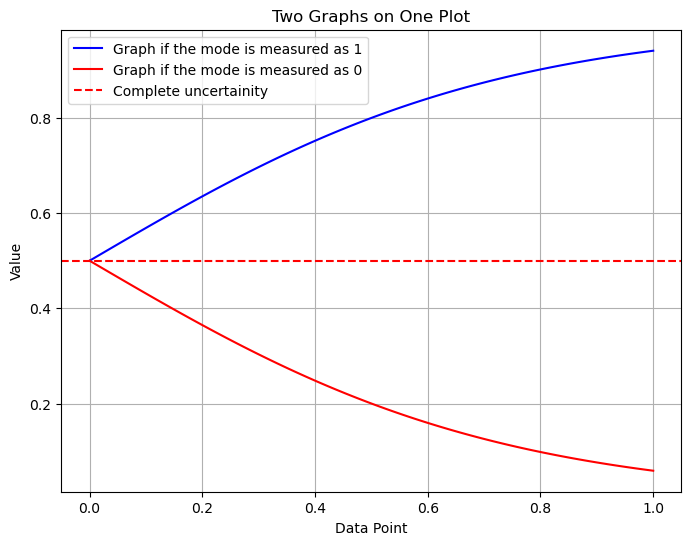

In [98]:
def sigmoid(x):
    return 1 / (1 + 2**(-4*x))

def makemodetempo(entry):
    sig_transform = sigmoid(entry['mode_confidence'])
     
    output = np.where(entry['mode'] == 1, sig_transform, 1 - sig_transform)
    
    return np.round(output,3)
    

In [99]:
dataset['meta_mode'] = dataset.apply(makemodetempo, axis=1)

In [100]:
dataset.head(2)

,id,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,release_date,artists_names,images_url,no_of_sections,tempo_confidence,mode_confidence,key_confidence,name_artist,meta_tempo,meta_mode
0,2Vc6NJ9PW9gD9q343XFRKx,"[Dark Trap, Underground Rap, Rap]",0.831,0.814,2,-7.364,1,0.4200,0.0598,0.0134,...,2017-09-05,[Ghostemane],https://i.scdn.co/image/ab67616d0000b27347fa48...,8,0.307,0.543,0.506,Mercury: Retrograde['Ghostemane'],149.318,0.818
1,7pgJBLVz5VmnL7uGHmRj6p,[Dark Trap],0.719,0.493,8,-7.230,1,0.0794,0.4010,0.0000,...,2020-11-20,"[Don Kenobi, SkyDxddy]",https://i.scdn.co/image/ab67616d0000b27391b3f8...,11,0.343,0.542,0.414,"Pathology['Don Kenobi', 'SkyDxddy']",137.895,0.818


<br>

### Removing the scales for now

<br>

### Rearranging the columns and setting the index to the id of the song

In [101]:
dataset.set_index('id', inplace=True, append=True)

In [102]:
dataset.head(2)

,,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,release_date,artists_names,images_url,no_of_sections,tempo_confidence,mode_confidence,key_confidence,name_artist,meta_tempo,meta_mode
,id,,,,,,,,,,,,,,,,,,,,,
0,2Vc6NJ9PW9gD9q343XFRKx,"[Dark Trap, Underground Rap, Rap]",0.831,0.814,2,-7.364,1,0.4200,0.0598,0.0134,0.0556,...,2017-09-05,[Ghostemane],https://i.scdn.co/image/ab67616d0000b27347fa48...,8,0.307,0.543,0.506,Mercury: Retrograde['Ghostemane'],149.318,0.818
1,7pgJBLVz5VmnL7uGHmRj6p,[Dark Trap],0.719,0.493,8,-7.230,1,0.0794,0.4010,0.0000,0.1180,...,2020-11-20,"[Don Kenobi, SkyDxddy]",https://i.scdn.co/image/ab67616d0000b27391b3f8...,11,0.343,0.542,0.414,"Pathology['Don Kenobi', 'SkyDxddy']",137.895,0.818


#### We will also be using the image url, popularity, and uri columns after calculating the cosine similarity (image url for the prototypical website to showcase the song url, and the popularity to sort the top k songs according to the popularity, and the uri for th website to open the song straight away)

### Transforming the release date only as the year
(might be experimenting with the month later on)

deleting weird dates:

In [103]:
print(len(dataset))
date_obj = pd.to_datetime(dataset['release_date'], errors='coerce').dt.year
nan_date_positions = np.where(date_obj.isna())[0]  # Get positions as a 1D array

# Drop rows with weird dates based on positions
dataset.drop(index=dataset.index[nan_date_positions], inplace=True)

print(len(dataset))

33964
33957


In [104]:
date_obj.index

MultiIndex([(    0, '2Vc6NJ9PW9gD9q343XFRKx'),
            (    1, '7pgJBLVz5VmnL7uGHmRj6p'),
            (    2, '0vSWgAlfpye0WCGeNmuNhy'),
            (    3, '0VSXnJqQkwuH2ei1nOQ1nu'),
            (    4, '4jCeguq9rMTlbMmPHuO7S3'),
            (    5, '6fsypiJHyWmeINsOLC1cos'),
            (    6, '0XfQbq7DaMOmVXgQ71eA6E'),
            (    7, '0LLeuNBWPOg3XA73yab3PT'),
            (    8, '37gqBnUAZe8BY8WR56kDNk'),
            (    9, '2ggqfj97qyiORmXoVFzP5j'),
            ...
            (33954, '5AtNetUUIVaGUOniIoRYs7'),
            (33955, '2pJC2rAkRmz3kxVugKsDD5'),
            (33956, '2nj0bzqYZR7PXs0BoQTW3V'),
            (33957, '4KM3VMk9QVuNGAOucnyxN0'),
            (33958, '4zNXw433Mi463n3TmKxpbG'),
            (33959, '4PMqy2vJjmv6ydGVqtCqPW'),
            (33960, '46bXU7Sgj7104ZoXxzz9tM'),
            (33961, '72DAt9Lbpy9EUS29OzQLob'),
            (33962, '6HXgExFVuE1c3cq9QjFCcU'),
            (33963, '6MAAMZImxcvYhRnxDLTufD')],
           names=[None, 'id'], length=33964

In [105]:
date_obj.drop(list(nan_date_positions), inplace=True, axis=0)

C:\Users\Karim\AppData\Local\Temp\ipykernel_18828\428889972.py:1: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  date_obj.drop(list(nan_date_positions), inplace=True, axis=0)


adding the year column:

In [106]:
dataset['release_year'] = date_obj.astype(int)

In [107]:
dataset.head(2)

,,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,artists_names,images_url,no_of_sections,tempo_confidence,mode_confidence,key_confidence,name_artist,meta_tempo,meta_mode,release_year
,id,,,,,,,,,,,,,,,,,,,,,
0,2Vc6NJ9PW9gD9q343XFRKx,"[Dark Trap, Underground Rap, Rap]",0.831,0.814,2,-7.364,1,0.4200,0.0598,0.0134,0.0556,...,[Ghostemane],https://i.scdn.co/image/ab67616d0000b27347fa48...,8,0.307,0.543,0.506,Mercury: Retrograde['Ghostemane'],149.318,0.818,2017
1,7pgJBLVz5VmnL7uGHmRj6p,[Dark Trap],0.719,0.493,8,-7.230,1,0.0794,0.4010,0.0000,0.1180,...,"[Don Kenobi, SkyDxddy]",https://i.scdn.co/image/ab67616d0000b27391b3f8...,11,0.343,0.542,0.414,"Pathology['Don Kenobi', 'SkyDxddy']",137.895,0.818,2020


<br><br><br><br>

## Creating the soup of the textual features

these include: 
- Artist Names
- Genres
- Could be experimenting with song titles

first, we clean these textual features to convert it all to lowercase and strip the spaces

In [108]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if the feature exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [109]:
# Apply clean_data function to your features.
dataset['lr_artists_names'] = dataset['artists_names'].apply(clean_data)
dataset['lr_genres'] = dataset['genres'].apply(clean_data)

now we create the "metadata soup", which is a string that contains all the metadata that you want to feed to your vectorizer (namely the song name, artists and genres).

The create_soup function will simply join all the required columns by a space. This is the final preprocessing step, and the output of this function will be fed into the word vector model.

In [110]:
def create_soup(x):
    return ' '.join(x['lr_artists_names']) + ' ' + ' '.join(x['lr_genres'])

In [111]:
# Create a new soup feature
dataset['soup'] = dataset.apply(create_soup, axis=1)

In [112]:
dataset.head(2)

,,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,tempo_confidence,mode_confidence,key_confidence,name_artist,meta_tempo,meta_mode,release_year,lr_artists_names,lr_genres,soup
,id,,,,,,,,,,,,,,,,,,,,,
0,2Vc6NJ9PW9gD9q343XFRKx,"[Dark Trap, Underground Rap, Rap]",0.831,0.814,2,-7.364,1,0.4200,0.0598,0.0134,0.0556,...,0.307,0.543,0.506,Mercury: Retrograde['Ghostemane'],149.318,0.818,2017,[ghostemane],"[darktrap, undergroundrap, rap]",ghostemane darktrap undergroundrap rap
1,7pgJBLVz5VmnL7uGHmRj6p,[Dark Trap],0.719,0.493,8,-7.230,1,0.0794,0.4010,0.0000,0.1180,...,0.343,0.542,0.414,"Pathology['Don Kenobi', 'SkyDxddy']",137.895,0.818,2020,"[donkenobi, skydxddy]",[darktrap],donkenobi skydxddy darktrap


## Creating the soup embeddings using Word2Vec from Gensim
#### Vectorizing the soup

In [113]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler


In [114]:
sentences = dataset['soup'].str.split()

In [115]:
word2vec_model = Word2Vec(sentences, vector_size=100, window=3, min_count=1)

One problem that arose was that if the genres were not listed in the same order, the cosine simiarity would decrease, which is not an effect we want considering our context. Therefore, a different way was implemented where for every type of textual features (artists,genre), a mean embedding of it was created so that they average out and the order would not matter

In [116]:
def get_embeddings(sentences):
    
    #print(sentences[0][0])
    #first_word = [x[0] for x in sentences]
    
    embeddings = [word2vec_model.wv[entry] for entry in sentences]
    
    return embeddings

def get_mean_embeddings(embeddings):
    mean_embedding = np.mean(embeddings, axis=0)
    
    return mean_embedding


In [117]:
artist_embeddings = get_embeddings(dataset['lr_artists_names'])
mean_artist_embeddings = [get_mean_embeddings(artist_embedding) for artist_embedding in artist_embeddings ]

In [118]:
genre_embeddings = get_embeddings(dataset['lr_genres'])
mean_genre_embeddings = [get_mean_embeddings(genre_embedding) for genre_embedding in genre_embeddings ]

In [119]:
def join_embeddings(list1, list2):
    
    # Initialize an empty list to store the concatenated vectors
    concatenated_list = []

    # Iterate through each pair of vectors and concatenate them
    for vector1, vector2 in zip(list1, list2):
        concatenated_vector = np.concatenate((vector1, vector2), axis=None)
        concatenated_list.append(concatenated_vector)

    # Convert the list of concatenated vectors to a numpy array
    matrix = np.array(concatenated_list)
    
    return matrix

In [120]:
embeddings_matrix = join_embeddings(mean_genre_embeddings,mean_artist_embeddings)

### Adding the numerical features to the feature vector

In [121]:
numerical_columns = ['meta_tempo',
 'meta_mode',
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'time_signature',
 'duration_ms',
 'no_of_sections',
 'release_year']

In [32]:
numerical_columns_to_normalise = ['meta_tempo', 'loudness', 'duration_ms']

numerical_columns_to_not_normalise = ['meta_mode',
 'danceability',
 'energy',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'time_signature',
 'no_of_sections',
'release_year']

Numerical features to be standardized:
- meta tempo
- loudness
- time signature
- duration_ms
- no_of_Sections
- release_year

In [122]:
matrix_to_be_normalised = dataset[numerical_columns].values
#matrix_to_not_be_normalised = dataset[numerical_columns_to_not_normalise].values

In [123]:
scaler = StandardScaler()
normalized_numerical_matrix = scaler.fit_transform(matrix_to_be_normalised)

In [34]:
#full_numerical_matrix =  np.hstack((matrix_to_be_normalised, matrix_to_not_be_normalised))

In [ ]:
#not too bad
#from sklearn.preprocessing import QuantileTransformer

#transformer = QuantileTransformer(output_distribution='normal')
#normalized_numerical_matrix = transformer.fit_transform(numerical_matrix)

**Combining both the embeddings matrix with the numerical matrix**:

In [124]:
combined_matrix = np.hstack((embeddings_matrix, normalized_numerical_matrix))

In [125]:
combined_matrix.shape

(33957, 214)

**Calculating the cosine similarity matrix**:

In [126]:
cosine_sim = cosine_similarity(combined_matrix)

In [127]:
cosine_sim.shape

(33957, 33957)

Test it with an input song

In [128]:
import textwrap
from IPython.display import display, HTML

def wrap_text(text, max_width):
    wrapped_name = textwrap.shorten(text, width=max_width, placeholder="...")
    return wrapped_name

In [129]:
# Function that takes in movie title as input and outputs most similar movies

def get_recommendations(title, cosine_sim, dataset, no_of_recs = 5):
    
    #get the index of the song title
    idx = dataset[dataset['name']==title].index[0][0]
    print(idx)
    if isinstance(idx, pd.Series):
        idx = idx[0]
    
    # Get the pairwsie similarity scores of all songs with that song
    scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the songs based on the similarity scores

    sorted_recs = sorted(scores, key= lambda x: x[1], reverse=True)

    # Get the scores of the x most similar songs
    sorted_recs = sorted_recs[1:no_of_recs+1]
    
    
    # Get the song indices
    
    rec_song_indices, rec_scores = zip(*sorted_recs)
    
    rec_song_names = dataset.iloc[list(rec_song_indices)]['name'].values
    rec_song_artists = dataset.iloc[list(rec_song_indices)]['artists_names'].values
    rec_song_popularity = list(enumerate(dataset.iloc[list(rec_song_indices)]['popularity'].values))
    rec_song_link = dataset.iloc[list(rec_song_indices)]['uri'].values
    
    
    
    sorted_songs_based_on_popularity = sorted(rec_song_popularity, key= lambda x: x[1], reverse=True)
    
        
    rec_song_indices_on_popularity, rec_scores_on_popularity = zip(*sorted_songs_based_on_popularity)
    
    
    print("Songs Recommendations for the song: ",title, "By:",  end=" ")
    
    for i in range(len(dataset.iloc[idx]['artists_names'])):
        if i == len(dataset.iloc[idx]['artists_names'])-1:
            print(dataset.iloc[idx]['artists_names'][i])
        else:
            print(dataset.iloc[idx]['artists_names'][i], end=" and ")
        
    print("\n")
    print(f"{'Song Title':<35} {'Artists':<25} {'Similarity Score':<30} {'Popularity'}")
    print("=" * 115)
        
    for i in rec_song_indices_on_popularity:
        
        wrapped_name = wrap_text(rec_song_names[i],35)
        
        
        formatted_name = f"{wrapped_name:<{35}}"
        formatted_artist = f"{rec_song_artists[i][0]:<{25}}"
        formatted_score = f"{rec_scores[i]:<{30}.2f}"
    
        print(f"{formatted_name} {formatted_artist} {formatted_score} {rec_song_popularity[i][1]}")
        
        print("\nLink To Song: ")
        spotify_uri = rec_song_link[i]
        link = f'<a href="{spotify_uri}" style="color: blue;">{spotify_uri}</a>'
        display(HTML(link))
        
        print("-"*100)
        



In [146]:
get_recommendations("SICKO MODE", cosine_sim, dataset = dataset, no_of_recs=10)

11828
Songs Recommendations for the song:  SICKO MODE By: Travis Scott


Song Title                          Artists                   Similarity Score               Popularity
Wasted (feat. Lil Uzi Vert)         Juice WRLD                0.94                           77

Link To Song: 


----------------------------------------------------------------------------------------------------
Walk It Talk It                     Migos                     0.97                           76

Link To Song: 


----------------------------------------------------------------------------------------------------
wokeuplikethis*                     Playboi Carti             0.92                           75

Link To Song: 


----------------------------------------------------------------------------------------------------
No Limit                            G-Eazy                    0.93                           72

Link To Song: 


----------------------------------------------------------------------------------------------------
Yamborghini High (feat. Juicy J)    A$AP Mob                  0.94                           65

Link To Song: 


----------------------------------------------------------------------------------------------------
No Limit REMIX (feat. A$AP...       G-Eazy                    0.93                           57

Link To Song: 


----------------------------------------------------------------------------------------------------
Versatile                           Kodak Black               0.92                           38

Link To Song: 


----------------------------------------------------------------------------------------------------
Juices                              Virtual Riot              0.93                           29

Link To Song: 


----------------------------------------------------------------------------------------------------
Bazaar                              Madcore                   0.92                           3

Link To Song: 


----------------------------------------------------------------------------------------------------
Testicle Twister                    Le Lion                   0.92                           0

Link To Song: 


----------------------------------------------------------------------------------------------------


In [ ]:
dataset[dat'name']

### Saving the cosine similarity numbers and refining the dataset to save only what we will be needing for the web-app

getting only the top 100 cosine similarity numbers:

In [131]:
top_100_cosine_sim = []
for i in range(len(cosine_sim)):
    
    if i%200==0:
        print(i)
    
    sorted_similarities = sorted(list(enumerate(cosine_sim[i])),  key= lambda x: x[1], reverse=True)
    
    
    top_100_cosine_sim.append(sorted_similarities[1:101])

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000
20200
20400
20600
20800
21000
21200
21400
21600
21800
22000
22200
22400
22600
22800
23000
23200
23400
23600
23800
24000
24200
24400
24600
24800
25000
25200
25400
25600
25800
26000
26200
26400
26600
26800
27000
27200
27400
27600
27800
28000
28200
28400
28600
28800
29000
29200
29400
29600
29800
30000
30200
30400
30600
30800
31000
31200
31400
31600
31800
32000
32200
32400
32600
32800
33000
33200
33400
33600
33800


testing to see if it works:

In [132]:
#get the index of the song title
idx = dataset[dataset['name']=="Skyscraper"].index[0][0]

print(idx)

if isinstance(idx, pd.Series):
    idx = idx[0]
    
top = top_100_cosine_sim[idx]

idx = [x[0] for x in top]

names = dataset.iloc[idx]['name']

names

11099


       id                    
13119  3lBRNqXjPp2j3JMTCXDTNO                               Best Thing I Never Had
11089  2WEjutXYTp4QW85jLDMcXQ                                             Sad Song
14826  4esOae7i4rqTbAu9o5Pxco                                         Girl on Fire
15398  4cAgkb0ifwn0FSHGXnr4F6                                           New Slaves
30477  048AbE9LVZn2qc4mKxoEO9      Finale (feat. Nicholas Petricca) - Netsky Remix
                                                       ...                        
13079  4NjR63Up0uMkQBlKvlZd1l                                            Stickwitu
10816  4mBJUbN4VLcpT36O4uf8t3                                                 Torn
1411   0JkLImaybz8gfwyyPpslVW    CLYDE (I Hope At Least One Of My Ex-Girlfriend...
30162  6uX6WZUzgIQ6a6diuUIWVg                                                 Fade
13255  0pj1IVRbwrFGnjn2FQ22r3                                         Lost In Love
Name: name, Length: 100, dtype: object

In [133]:
import pickle

In [134]:
dataset.head(2)

,,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,tempo_confidence,mode_confidence,key_confidence,name_artist,meta_tempo,meta_mode,release_year,lr_artists_names,lr_genres,soup
,id,,,,,,,,,,,,,,,,,,,,,
0,2Vc6NJ9PW9gD9q343XFRKx,"[Dark Trap, Underground Rap, Rap]",0.831,0.814,2,-7.364,1,0.4200,0.0598,0.0134,0.0556,...,0.307,0.543,0.506,Mercury: Retrograde['Ghostemane'],149.318,0.818,2017,[ghostemane],"[darktrap, undergroundrap, rap]",ghostemane darktrap undergroundrap rap
1,7pgJBLVz5VmnL7uGHmRj6p,[Dark Trap],0.719,0.493,8,-7.230,1,0.0794,0.4010,0.0000,0.1180,...,0.343,0.542,0.414,"Pathology['Don Kenobi', 'SkyDxddy']",137.895,0.818,2020,"[donkenobi, skydxddy]",[darktrap],donkenobi skydxddy darktrap


In [135]:
dataset.columns

Index(['genres', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'uri', 'name',
       'popularity', 'release_date', 'artists_names', 'images_url',
       'no_of_sections', 'tempo_confidence', 'mode_confidence',
       'key_confidence', 'name_artist', 'meta_tempo', 'meta_mode',
       'release_year', 'lr_artists_names', 'lr_genres', 'soup'],
      dtype='object')

In [136]:
refined_columns = ['name',
 'uri',
 'artists_names',
 'release_year',
 'popularity',
 'images_url']

In [137]:
refined_df = dataset[refined_columns]

In [138]:
def format_song_with_artists(row):
    return f"{row['name']} - {', '.join(row['artists_names'])}"

In [139]:
refined_df['song-artist'] = refined_df.apply(format_song_with_artists, axis=1)

C:\Users\Karim\AppData\Local\Temp\ipykernel_18828\396183713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refined_df['song-artist'] = refined_df.apply(format_song_with_artists, axis=1)


In [140]:
refined_df.head(2)

,,name,uri,artists_names,release_year,popularity,images_url,song-artist
,id,,,,,,,
0,2Vc6NJ9PW9gD9q343XFRKx,Mercury: Retrograde,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,[Ghostemane],2017,2,https://i.scdn.co/image/ab67616d0000b27347fa48...,Mercury: Retrograde - Ghostemane
1,7pgJBLVz5VmnL7uGHmRj6p,Pathology,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,"[Don Kenobi, SkyDxddy]",2020,37,https://i.scdn.co/image/ab67616d0000b27391b3f8...,"Pathology - Don Kenobi, SkyDxddy"


In [141]:
rounded_matrix = [[(x, round(y, 3)) for x, y in row] for row in top_100_cosine_sim]

In [142]:
file_path = "D:/Python/Graduate Exercising/song_recommender/artifacts/unique_top_100_cos_similarity.pkl"
pickle.dump(rounded_matrix, open(file_path, 'wb'))

In [143]:
file_path_2 = "D:/Python/Graduate Exercising/song_recommender/artifacts/unique_refined_dataset.pkl"
pickle.dump(refined_df, open(file_path_2, 'wb'))

## For the APP

In [ ]:
#get the index of the song title
#idx = dataset[dataset['name']=="Girl on Fire"].index[0][0]

#print(idx)

#if isinstance(idx, pd.Series):
#    idx = idx[0]
    
#top = top_100_cosine_sim[idx]

#idx = [x[0] for x in top]

#names = dataset.iloc[idx]['name']

#names

In [88]:
#x = pd.read_pickle('artifacts/refined_dataset.pkl')
#y = pickle.load(open('artifacts/top_100_cos_similarity.pkl','rb'))